## **Evaluate 🤗's BigBirdPegasus and LONGt5 on Pubmed**

Install dependencies and define packages. (copy all from neuromatch)

In [ ]:
#@title
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
#@title
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
%%capture
!pip3 install datasets
!pip3 install rouge_score
!pip3 install git+https://github.com/huggingface/transformers
!pip3 install sentencepiece

Imports

In [ ]:
import numpy as np
from pynvml import *
from transformers import pipeline
from datasets import load_dataset, load_metric
import torch
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [ ]:
!/usr/local/cuda/bin/nvcc --version

!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed Jun 15 17:29:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |            

Let's first install `transformers`, `datasets`, `rouge_score` and `sentencepiece`.

As mentioned above, we will evaluate **BigBirdPegasus** on the **_pubmed_** dataset using the **Rouge-2** metric. For this, let's 
import the two loading functions `load_dataset` and `load_metric`. Futher, we import the `BigBirdPegasusForConditionalGeneration` and `AutoTokenizer` tokenizer.

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Pubmed dataset

### Pubmed dataset loading

In [ ]:
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer

Let's define some variables which will be useful later on.

In [ ]:
#%%
pubmed = load_dataset('scientific_papers', 'pubmed', split='test')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/119924 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6633 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6658 [00:00<?, ? examples/s]

Dataset scientific_papers downloaded and prepared to /root/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f. Subsequent calls will reuse this data.


### Preprocessing for pubmed dataset

In [ ]:
def remove_new_lines(x):
    x['article'] = ''.join(x['article'].splitlines())
    x['abstract'] = ''.join(x['abstract'].splitlines())
    return x

In [ ]:
pubmed = pubmed.map(remove_new_lines)

Parameter 'function'=<function remove_new_lines at 0x7ff79a15db90> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/6658 [00:00<?, ?ex/s]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.35M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"]
    )  #not truncate to see tokens distribution
    return model_inputs

In [ ]:
pubmed = pubmed.map(preprocess_function, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4777 > 4096). Running this sequence through the model will result in indexing errors


In [ ]:
def compute_tok_length(example):
    return {"art_n_tokens": len(example["input_ids"])}

In [ ]:
pubmed = pubmed.map(compute_tok_length)

  0%|          | 0/6658 [00:00<?, ?ex/s]

In [ ]:
pubmed.num_rows

6658

In [ ]:
import matplotlib.pyplot as plt

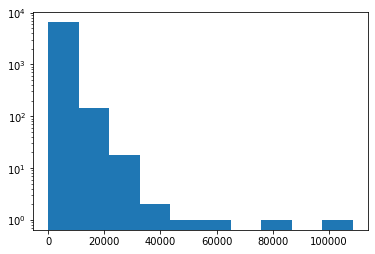

In [ ]:
plt.hist(pubmed['art_n_tokens'], log=True);

In [ ]:
pubmed.filter(lambda x: x["art_n_tokens"] <= 6000).num_rows

  0%|          | 0/7 [00:00<?, ?ba/s]

5479

In [ ]:
#%%
pubmed = pubmed.filter(lambda x: x["art_n_tokens"] <= 4096)

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
pubmed = pubmed.filter(lambda x: x["art_n_tokens"] > 500)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
pubmed.num_rows

4167

In [ ]:
def preprocess_function2(examples):
    model_inputs = tokenizer(
        examples["abstract"]
    )  #not truncate to see tokens distribution
    return model_inputs

In [ ]:
pubmed = pubmed.map(preprocess_function2, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
def compute_tok_length2(example):
    return {"ab_n_tokens": len(example["input_ids"])}

In [ ]:
pubmed = pubmed.map(compute_tok_length2)

  0%|          | 0/4167 [00:00<?, ?ex/s]

In [ ]:
pubmed = pubmed.filter(lambda x: x["ab_n_tokens"] > 50)

  0%|          | 0/5 [00:00<?, ?ba/s]

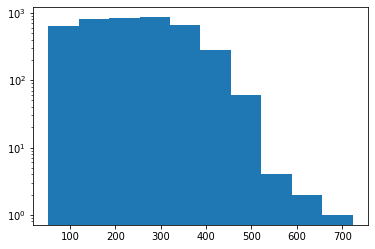

In [ ]:
plt.hist(pubmed['ab_n_tokens'], log=True);

In [ ]:
print(pubmed.sort('ab_n_tokens', reverse=True)[:10]['ab_n_tokens'])
print(pubmed.sort('ab_n_tokens', reverse=False)[:10]['ab_n_tokens'])

[723, 653, 612, 569, 531, 527, 522, 518, 517, 517]
[52, 53, 54, 54, 55, 55, 55, 56, 56, 56]


In [ ]:
pubmed.num_rows

4165

In [ ]:
import numpy as np
print(np.mean(pubmed['art_n_tokens']))
print(np.median(pubmed['art_n_tokens']))
print(np.quantile(pubmed['art_n_tokens'], 0.9))

print(np.mean(pubmed['ab_n_tokens']))
print(np.median(pubmed['ab_n_tokens']))
print(np.quantile(pubmed['ab_n_tokens'], 0.9))

2349.570468187275
2300.0
3655.0
238.1202881152461
235.0
376.0


### (Dummy) baseline metrics evaluations

In [ ]:
rouge = load_metric("rouge")

In [ ]:
#creating baseline only 1st sentence
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
def evaluate_baseline1(dataset):
    summaries = [three_sentence_summary(text) for text in dataset['article']]
    return rouge.compute(predictions=summaries, references=dataset['abstract'])

score = evaluate_baseline1(pubmed)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 33.02, 'rouge2': 12.59, 'rougeL': 18.4, 'rougeLsum': 21.01}

In [ ]:
def two_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:2])
def evaluate_baseline2(dataset):
    summaries = [two_sentence_summary(text) for text in dataset['article']]
    return rouge.compute(predictions=summaries, references=dataset['abstract'])

score = evaluate_baseline2(pubmed)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 31.82, 'rouge2': 11.64, 'rougeL': 18.33, 'rougeLsum': 19.93}

In [ ]:
def one_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:1])
def evaluate_baseline3(dataset):
    summaries = [one_sentence_summary(text) for text in dataset['article']]
    return rouge.compute(predictions=summaries, references=dataset['abstract'])

score = evaluate_baseline3(pubmed)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 24.92, 'rouge2': 8.94, 'rougeL': 15.65, 'rougeLsum': 15.66}

### Big Bird Inference on Pubmed test set (preprocessed)

In [ ]:
#DATASET_NAME = "pubmed"
#DEVICE = "cuda"
#CACHE_DIR = DATASET_NAME #have removed this part but can put it back in again.
#MODEL_ID = f"google/bigbird-pegasus-large-{DATASET_NAME}"

To begin with, let's take a look at the PubMed dataset ([click to see on 🤗Datasets Hub](https://huggingface.co/datasets/scientific_papers)).
PubMed consists of scientific papers in the field of medicine. The dataset splits each paper into the *article*, and the *abstract* whereas the article consists of the whole paper minus the abstract. Thus, the input to be summarized is defined by the article and the gold label by the abstract.

The following table summarizes the size of the *train*, *validation*, and *test* split of the dataset.

|               |Training | Validation | Test |
|---------------|---------|------------|------|
| Total samples | 119924  | 6633       | 6658 |

In this notebook, we are only interested in evaluating *BigBird*. To do so, let's download the *test* split of the `pubmed` dataset. This can take a couple of minutes **☕** .

The official checkpoint `google/bigbird-pegasus-large-pubmed` ([click to see on 🤗Model Hub](https://huggingface.co/google/bigbird-pegasus-large-pubmed)) has already been fine-tuned on pubmed, so we can simply load the weights are run the model in inference mode.

In [ ]:
MODEL_ID = "google/bigbird-pegasus-large-pubmed"

In [ ]:
summarizer = pipeline("summarization", model=MODEL_ID, tokenizer=MODEL_ID, framework="pt", device=0)

In [ ]:
print_gpu_utilization()

GPU memory occupied: 3269 MB.


In [ ]:
from transformers.pipelines.pt_utils import KeyDataset

In [ ]:
sam = pubmed.select(range(6))

In [ ]:
%%time
results=[]
for out in summarizer(KeyDataset(pubmed, "article"), batch_size=3, max_length=256, num_beams=5, early_stopping=True, length_penalty=0.8, no_repeat_ngram_size=3, clean_up_tokenization_spaces=True):
    print(out[0]['summary_text'].replace('<n>',''))
    results.append(out[0]['summary_text'].replace('<n>',''))

4 h 13 min to run with batch=3

In [ ]:
#rouge.compute(predictions=results[0], references=pubmed['abstract'][0])

In [ ]:
#from tqdm.auto import tqdm

In [ ]:
#results = []
for text in tqdm(_input_text_chunks, total=len(_input_text_chunks)):

    _summarized = summarizer(
                    text,
                    min_length=16, 
                    max_length=256,
                    no_repeat_ngram_size=3, 
                    clean_up_tokenization_spaces=True,
                    early_stopping=True,
                    do_sample=True,
                    top_p=0.9,
                    top_k=50,
                    repetition_penalty=3.7,
                )

    results.append(_summarized[0]['summary_text'])

In [ ]:
#model = BigBirdPegasusForConditionalGeneration.from_pretrained(MODEL_ID).to(DEVICE)
#model.config.attention_type, model.config.block_size
#tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

### Evaluation BigBird (using stored summarized in pickle file)

Evaluation for infered results (batch3 and saved as results)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
summ = pd.read_pickle('/content/drive/MyDrive/NLP_thesis/results_b3_bigbird/res_bigbird_pubmed')

In [ ]:
len(summ)

4165

Performance metrics evaluation

In [ ]:
def evaluate_bb(dataset, dataset2):
    return rouge.compute(predictions=dataset, references=dataset2['abstract'])

In [ ]:
score = evaluate_bb(summ, pubmed)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 43.06, 'rouge2': 18.94, 'rougeL': 26.49, 'rougeLsum': 26.48}

In [ ]:
summ[0]

"anxiety is the most prominent and prevalent mood disorder in parkinson's disease ( pd ) ; however, its neural basis and best treatment practices remain meager and lags far behind that of depression. the aim of this study was to examine the influence of anxiety on cognition in pd by comparing groups of pd patients with and without anxiety, in order to better understand the neural basis of anxiety and its impact on cognition, as well as the best treatment strategies for anxiety. a total of 17 patients with pd with anxiety ( pda+ ) and 33 patients without anxiety ( rpda ) were included in this study, matched in age, disease duration, hoehn and yahr ( h&y ) stages, and self - reported depression score. all participants completed a battery of neuropsychological tests including the mini - mental state exam, trail making test, digit span forward and backward subtests of the wechsler memory scale - iii, lm - i immediate recall, visuospatial construction subtest of the tmt - b, verbal learning

Now do the same for the full dataset without removing papers longer than 4096 tokens:

Significantly higher than baseline but only with the papers with less than 4096 tokens and the following parameters for summary generation:
batch_size=3, max_length=256, num_beams=5, early_stopping=True, length_penalty=0.8, no_repeat_ngram_size=3, clean_up_tokenization_spaces=True


### old inference with map


In [ ]:
ts = tokenizer(pubmed['article'][0], padding="max_length", max_length=4096, return_tensors="pt", truncation=True)

In [ ]:
%%timeit
pred = model.generate(**(ts.to(DEVICE)), max_length=256, num_beams=5, early_stopping=True, length_penalty=0.8, no_repeat_ngram_size=3)
print(tokenizer.decode(pred[0], skip_special_tokens=True, clean_up_tokenization_spaces=True).replace('<n>',''))

/usr/local/lib/python3.7/dist-packages/transformers/models/bigbird_pegasus/modeling_bigbird_pegasus.py:809: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from


although anxiety is the most prominent and prevalent mood disorder in patients with parkinson's disease ( pd ), few studies have examined the relationship between anxiety and cognition. the aim of this study was to examine the influence of anxiety on cognition in pd by comparing pd patients with and without anxiety, in order to better understand the neural correlates of anxiety and its influence on cognition, especially in the central executive and attentional systems. using a cross - sectional design, the mini - mental state examination, neuropsychological tests of attention, memory, and verbal memory were administered to a refined sample of 17 patients with pd with anxiety ( pda+ ) and to 33 patients without anxiety ( rpd ; pda ). a hierarchical multiple linear regression showed that pd+ patients with anxiety had worse performance on the digit span forward test part b ( t(19 ) = 2.29, p = 0.033 ) compared to pda patients, whereas the pda group had worse digit span backward test perfo

In [ ]:
%%timeit
pred = model.generate(**(ts.to(DEVICE)), max_length=256, num_beams=5, early_stopping=True, length_penalty=0.8, no_repeat_ngram_size=3)
g= tokenizer.batch_decode(pred, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0].replace('<n>','')

/usr/local/lib/python3.7/dist-packages/transformers/models/bigbird_pegasus/modeling_bigbird_pegasus.py:809: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from


1 loop, best of 5: 6.75 s per loop


Number of examples:

In [ ]:
print_gpu_utilization()

GPU memory occupied: 3257 MB.


In [ ]:
torch.cuda.empty_cache()

`BigBirdPegasus` makes use of *block sparse attention*. Let's verify the `config`'s attention type and the `block_size`.

Next, we will take a look at the length distribution of the dataset. The following table shows the *median* and the 90% quantile of the article, and abstract (summary). 

|                 | Median | 90%-ile |
|-----------------|--------|---------|
| Articles Length | 2715   | 6101    |
| Summary Length  | 212    | 318     |

`BigBirdPegasus` can handle sequence up to a length of **4096** which is significantly higher than the median input length of **2715**. However, many input samples are longer than **4096**, which consequently need to be truncated. 
The summaries have a median length of **212** with 90% being shorter than **318**. Given this data, 256 seems to be a reasonable choice as the model's maximum generation length.

Now we can write the evaluation function for BigBirdPegasus.
First, we tokenize each *article* up to a maximum length of 4096 tokens.
We will make use of beam search (with `num_beams=5` & `length_penalty=0.8`) to generate the predicted *abstract* of the *article*. Finally, the predicted *abstract* tokens are decoded and the resulting predicted *abstract* string is saved in the batch.

In [ ]:
def prep(examples):
    model_inputs = tokenizer(
        examples["article"], max_length=4096, truncation=True, padding="max_length", return_tensors="pt"
    )
    # Set up the tokenizer for targets
    return model_inputs

In [ ]:
tokenizer.batch

Dataset({
    features: ['article', 'abstract', 'section_names', 'input_ids', 'attention_mask', 'art_n_tokens', 'ab_n_tokens'],
    num_rows: 5407
})

In [ ]:
def generate_answer(batch):
  inputs_dict = tokenizer(batch["article"], padding="max_length", max_length=4096, return_tensors="pt", truncation=True)
  inputs_dict = {k: inputs_dict[k].to(DEVICE) for k in inputs_dict}
  predicted_abstract_ids = model.generate(**inputs_dict, max_length=256, num_beams=5, early_stopping=True, length_penalty=0.8, no_repeat_ngram_size=3)
  batch["predicted_abstract"] = tokenizer.decode(predicted_abstract_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True).replace('<n>','')
  print(batch["predicted_abstract"])
  return batch

In [ ]:
#dataset_small = pubmed.select(range(2))
#result_small = dataset_small.map(generate_answer)

#rouge.compute(predictions=result_small["predicted_abstract"], references=result_small["abstract"])

  0%|          | 0/2 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/bigbird_pegasus/modeling_bigbird_pegasus.py:809: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from


although anxiety is the most prominent and prevalent mood disorder in patients with parkinson's disease ( pd ), few studies have examined the relationship between anxiety and cognition.<n> the aim of this study was to examine the influence of anxiety on cognition in pd by comparing pd patients with and without anxiety, in order to better understand the neural correlates of anxiety and its influence on cognition, especially in the central executive and attentional systems. using a cross - sectional design,<n> the mini - mental state examination, neuropsychological tests of attention, memory, and verbal memory were administered to a refined sample of 17 patients with pd with anxiety ( pda+ ) and to 33 patients without anxiety ( rpd ; pda )<n>. a hierarchical multiple linear regression showed that pd+ patients with anxiety had worse performance on the digit span forward test part b ( t(19 ) = 2.29, p = 0.033 ) compared to pda patients, whereas the pda group had worse digit span backward t

In [ ]:
def evaluate_perf(dataset):
  rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
  return dict((rn, round((rouge.compute(predictions=dataset["predicted_abstract"], references=dataset["abstract"]))[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)

In [ ]:
#%%time
#evaluate_perf(result_small)

CPU times: user 705 ms, sys: 14.1 ms, total: 719 ms
Wall time: 713 ms


{'rouge1': 44.0, 'rouge2': 17.17, 'rougeL': 24.74, 'rougeLsum': 24.74}

In [ ]:
#torch.cuda.reset_max_memory_allocated

<function torch.cuda.memory.reset_max_memory_allocated>

In [ ]:
%%time
# test
#test = pubmed.shuffle(seed=42).select(range(40))
#res_test = test.map(generate_answer)

Evaluation on all dataset.

In [ ]:
summ = pubmed.map(generate_answer)

Because of the very large input size of ~ 4K tokens in this notebook, it would take over (time) to evaluate the whole filtered test dataset. For the sake of this notebook, we'll only evaluate the first 600 examples. Therefore, we cut the 6000+ samples to just 600 samples using 🤗Datasets' convenient `.select()` function.

Evaluated section of first 800 examples from pubmed (with the filtered dataset of outliers (article and abstract length).

In [ ]:
pubmed = pubmed.select(range(800))

Alright, now let's map each sample to the predicted *abstract*. This will take *ca.* 2 hours if you have been given a fast GPU.

In [ ]:
result = pubmed.map(generate_answer)

  0%|          | 0/800 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/bigbird_pegasus/modeling_bigbird_pegasus.py:809: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from


although anxiety is the most prominent and prevalent mood disorder in patients with parkinson's disease ( pd ), few studies have examined the relationship between anxiety and cognition.<n> the aim of this study was to examine the influence of anxiety on cognition in pd by comparing pd patients with and without anxiety, in order to better understand the neural correlates of anxiety and its influence on cognition, especially in the central executive and attentional systems. using a cross - sectional design,<n> the mini - mental state examination, neuropsychological tests of attention, memory, and verbal memory were administered to a refined sample of 17 patients with pd with anxiety ( pda+ ) and to 33 patients without anxiety ( rpd ; pda )<n>. a hierarchical multiple linear regression showed that pd+ patients with anxiety had worse performance on the digit span forward test part b ( t(19 ) = 2.29, p = 0.033 ) compared to pda patients, whereas the pda group had worse digit span backward t

Finally, we can evaluate the predictions using the *rouge* metric.

In [ ]:
evaluate_perf(result) #model.generate(**inputs_dict, max_length=256, num_beams=5, early_stopping=True, length_penalty=2.1, no_repeat_ngram_size=3)

{'rouge1': 43.92, 'rouge2': 19.27, 'rougeL': 26.71, 'rougeLsum': 26.67}

In [ ]:
rouge.compute(predictions=result["predicted_abstract"], references=result["abstract"])

{'rouge1': AggregateScore(low=Score(precision=0.4629948492298602, recall=0.4336013945148705, fmeasure=0.432259195823792), mid=Score(precision=0.47355152845489684, recall=0.441339579538801, fmeasure=0.43917039285285475), high=Score(precision=0.483559435756528, recall=0.4492371856207626, fmeasure=0.44663420261263365)),
 'rouge2': AggregateScore(low=Score(precision=0.19993711850865242, recall=0.18381346190835712, fmeasure=0.18454026646408322), mid=Score(precision=0.20994262476728198, recall=0.1912680833185023, fmeasure=0.19266185670643665), high=Score(precision=0.2198262444426685, recall=0.1993838463711878, fmeasure=0.20097652579006786)),
 'rougeL': AggregateScore(low=Score(precision=0.2793829952110849, recall=0.2613649381136388, fmeasure=0.25982766082926356), mid=Score(precision=0.2883453123867744, recall=0.26875551591421387, fmeasure=0.26711076522303356), high=Score(precision=0.29794691081459385, recall=0.2770937651718672, fmeasure=0.27466062155051707)),
 'rougeLsum': AggregateScore(low

### Baseline evaluation for pubmed (not sure if it's the full one or the one pre-processed (just quickly check)

In [ ]:
#creating baseline only 1st sentence
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
def evaluate_baseline1(dataset):
    summaries = [three_sentence_summary(text) for text in dataset['article']]
    return rouge.compute(predictions=summaries, references=dataset['abstract'])

score = evaluate_baseline1(pubmed)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 33.23, 'rouge2': 13.25, 'rougeL': 19.06, 'rougeLsum': 21.65}

In [ ]:
def two_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:2])
def evaluate_baseline2(dataset):
    summaries = [two_sentence_summary(text) for text in dataset['article']]
    return rouge.compute(predictions=summaries, references=dataset['abstract'])

score = evaluate_baseline2(pubmed)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 32.34, 'rouge2': 12.44, 'rougeL': 19.13, 'rougeLsum': 20.71}

In [ ]:
def one_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:1])
def evaluate_baseline3(dataset):
    summaries = [one_sentence_summary(text) for text in dataset['article']]
    return rouge.compute(predictions=summaries, references=dataset['abstract'])

score = evaluate_baseline3(pubmed)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 25.4, 'rouge2': 9.61, 'rougeL': 16.49, 'rougeLsum': 16.47}

For our 600 samples, we get a *Rouge-2* score of **19.6** 🔥🔥🔥.

**Note**: As stated in the [official paper](https://arxiv.org/pdf/2007.14062.pdf) *BigBirdPegasus* achieves a new state-of-the-art of **20.65** Rouge-2 score on PubMed. Evaluation in this notebook might be slightly worse since a different `length_penalty` is used for generation and data pre-processing is kept as simple as possibe (no "*newline*" removal and space removal before special tokens).

In case you want to evaluate [`google/bigbird-pegasus-large-arxiv`](https://huggingface.co/google/bigbird-pegasus-large-pubmed) on `arxiv` dataset from [`scientific_papers`](https://huggingface.co/datasets/scientific_papers), you can just change the `DATASET_NAME` to `arxiv` in the cell above.

## Pubmed summarization dataset

In [ ]:
pubsum = load_dataset("ccdv/pubmed-summarization", split='test', download_mode='force_redownload')

No config specified, defaulting to: pubmed-summarization/section


Generating train split:   0%|          | 0/119924 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6633 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6658 [00:00<?, ? examples/s]

Dataset pubmed-summarization downloaded and prepared to /root/.cache/huggingface/datasets/ccdv___pubmed-summarization/section/1.0.0/f9a2a592892a29ff6b5579891a7d5fcc3e15642540af26d1f6ac99086dc9fecd. Subsequent calls will reuse this data.


In [ ]:
#pubsum = load_dataset("scientific_papers", "pubmed", split="test")

Reusing dataset scientific_papers (/root/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


In [ ]:
len(pubsum['article'])

6658

In [ ]:
def remove_new_lines(x):
    x['article'] = ''.join(x['article'].splitlines())
    x['abstract'] = ''.join(x['abstract'].splitlines())
    return x

In [ ]:
pubsum = pubsum.map(remove_new_lines)

  0%|          | 0/6658 [00:00<?, ?ex/s]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")

In [ ]:
#!pip3 install evaluate

In [ ]:
#import evaluate
#importing evaluate takes about 1 gb on gpu, let's run it afterwards

In [ ]:
print_gpu_utilization()

GPU memory occupied: 2 MB.


In [ ]:
from transformers import LongT5ForConditionalGeneration


model = (
     LongT5ForConditionalGeneration.from_pretrained("Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")
     .to(DEVICE).half())
     #.half())

In [ ]:
print_gpu_utilization() #model with weights about 4 GB, with half() even more gpu memeory used

GPU memory occupied: 4243 MB.


In [ ]:
art = pubsum['article'][0]

In [ ]:
input_ids = tokenizer(art, max_length=16384, truncation=True, return_tensors="pt").input_ids.to(DEVICE)

#model = LongT5ForConditionalGeneration.from_pretrained("Stancld/longt5-tglobal-large-16384-pubmed-3k_steps", return_dict_in_generate=True).to("cuda")


In [ ]:
print_gpu_utilization()

GPU memory occupied: 4179 MB.


In [ ]:
sequences = model.generate(input_ids, max_length=512, num_beams=3)

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:770: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [ ]:
sum = tokenizer.decode(sequences[0], skip_special_tokens=True)

In [ ]:
sum

"anxiety affects quality of life in patients living with parkinson's disease ( pd ) more so than overall cognitive status, motor deficits, apathy, and depression. however, our current understanding of anxiety and its impact on cognition in pd remains meager and lags far behind that of depression. we hypothesized that anxiety negatively influences attentional set - shifting and working memory in pd patients compared to pd patients without anxiety while excluding depression. seventeen pd patients with anxiety and thirty - three pd patients without anxiety were included in this study. anxiety was assessed using the hospital anxiety and depression scale ( hads ). anxiety was assessed using the trail making test part b ( t(46 ) = 2.03, p = 0.048 ) and the digit span forward subtest ( t(48 ) = 2.22, p = 0.031 ) and backward subtest ( u = 190.5, p = 0.016 ) compared to the pda group. no differences were found for tmt - a performance ( u = 256, p = 0.62 ) ; however, the pda+ group had worse pe

In [ ]:
print(tokenizer.decode(sequences[0], skip_special_tokens=True)) #all default settings

anxiety is a key contributor to decreased quality of life in parkinson's disease


In [ ]:
scor = rouge.compute(predictions=[sum], references=[pubsum["abstract"][0]])

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(scor[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 44.94, 'rouge2': 15.35, 'rougeL': 23.82, 'rougeLsum': 23.82}

In [ ]:
summary = tokenizer.batch_decode(sequences)

Batch inference

In [ ]:
inputs_dict = tokenizer(pubsum["article"][0], max_length=16384, padding="max_length", truncation=True, return_tensors="pt")

In [ ]:
inputs_dict

{'input_ids': tensor([[6261, 2603,    7,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
inputs_dict.input_ids

tensor([[6261, 2603,    7,  ...,    0,    0,    0]])

In [ ]:
inputs_dict.attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
def generate_answers(batch):
     inputs_dict = tokenizer(
         batch["article"], max_length=16384, padding="max_length", truncation=True, return_tensors="pt"
     )
     input_ids = inputs_dict.input_ids.to(DEVICE)
     attention_mask = inputs_dict.attention_mask.to(DEVICE)
     output_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=512, num_beams=3, early_stopping=True)
     batch["predicted_abstract"] = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
     return batch

Already reduce tokens maybe?

In [ ]:
def generate_answers(batch):
     inputs_dict = tokenizer(batch["article"], max_length=16384, padding="max_length", truncation=True, return_tensors="pt")
     inputs_dict = {k: inputs_dict[k].to(DEVICE) for k in inputs_dict}
     output_ids = model.generate(**inputs_dict, max_length=512, num_beams=3, early_stopping=True)
     batch["predicted_abstract"] = tokenizer.decode(output_ids[0], skip_special_tokens=True)
     print(batch["predicted_abstract"])
     return batch

In [ ]:
def generate_answer(batch):
  inputs_dict = tokenizer(batch["article"], padding="max_length", max_length=4096, return_tensors="pt", truncation=True)
  inputs_dict = {k: inputs_dict[k].to(DEVICE) for k in inputs_dict}
  predicted_abstract_ids = model.generate(**inputs_dict, max_length=256, num_beams=5, early_stopping=True, length_penalty=0.8, no_repeat_ngram_size=3)
  batch["predicted_abstract"] = tokenizer.decode(predicted_abstract_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
  print(batch["predicted_abstract"])
  return batch

In [ ]:
print_gpu_utilization()

GPU memory occupied: 4243 MB.


In [ ]:
rouge = evaluate.load("rouge")

In [ ]:
res = pubsum.map(generate_answers) #with half it works (super close to gpu memory max)

  0%|          | 0/6658 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:770: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


KeyboardInterrupt: ignored

In [ ]:
res

NameError: ignored

In [ ]:
rouge.compute(predictions=res["predicted_abstract"], references=res["abstract"])

test if model works

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"]
    )  #not truncate to see tokens distribution
    return model_inputs

In [ ]:
pubsum = pubsum.map(preprocess_function, batched=True)

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
def compute_tok_length(example):
    return {"art_n_tokens": len(example["input_ids"])}

In [ ]:
pubsum = pubsum.map(compute_tok_length)

  0%|          | 0/6658 [00:00<?, ?ex/s]

In [ ]:
pubsum.num_rows

6658

In [ ]:
import matplotlib.pyplot as plt

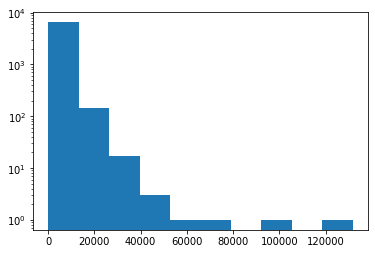

In [ ]:
plt.hist(pubsum['art_n_tokens'], log=True);

In [ ]:
pubsum.filter(lambda x: x["art_n_tokens"] <= 16384).num_rows

  0%|          | 0/7 [00:00<?, ?ba/s]

6580

In [ ]:
#%%
#pubmed = pubmed.filter(lambda x: x["art_n_tokens"] <= 4096)

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
pubsum.filter(lambda x: x["art_n_tokens"] < 100).num_rows

  0%|          | 0/7 [00:00<?, ?ba/s]

6

In [ ]:
#pubmed = pubmed.filter(lambda x: x["art_n_tokens"] > 500)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
#pubmed.num_rows

4167

In [ ]:
def preprocess_function2(examples):
    model_inputs = tokenizer(
        examples["abstract"]
    )  #not truncate to see tokens distribution
    return model_inputs

In [ ]:
pubsum = pubsum.map(preprocess_function2, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
def compute_tok_length2(example):
    return {"ab_n_tokens": len(example["input_ids"])}

In [ ]:
pubmed = pubmed.map(compute_tok_length2)

  0%|          | 0/4167 [00:00<?, ?ex/s]

In [ ]:
pubmed = pubmed.filter(lambda x: x["ab_n_tokens"] > 50)

  0%|          | 0/5 [00:00<?, ?ba/s]

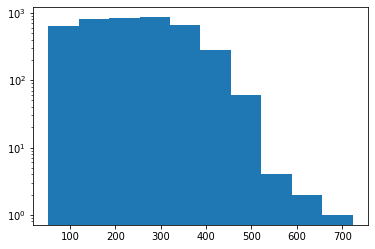

In [ ]:
plt.hist(pubmed['ab_n_tokens'], log=True);

In [ ]:
print(pubmed.sort('ab_n_tokens', reverse=True)[:10]['ab_n_tokens'])
print(pubmed.sort('ab_n_tokens', reverse=False)[:10]['ab_n_tokens'])

[723, 653, 612, 569, 531, 527, 522, 518, 517, 517]
[52, 53, 54, 54, 55, 55, 55, 56, 56, 56]


In [ ]:
pubmed.num_rows

4165

In [ ]:
import numpy as np
print(np.mean(pubmed['art_n_tokens']))
print(np.median(pubmed['art_n_tokens']))
print(np.quantile(pubmed['art_n_tokens'], 0.9))

print(np.mean(pubmed['ab_n_tokens']))
print(np.median(pubmed['ab_n_tokens']))
print(np.quantile(pubmed['ab_n_tokens'], 0.9))

2349.570468187275
2300.0
3655.0
238.1202881152461
235.0
376.0
